Calculating mean and std...
Dataset mean: [0.507876455783844, 0.507876455783844, 0.507876455783844]
Dataset std:  [0.25019553303718567, 0.25019553303718567, 0.25019553303718567]
Begin Training...
Epoch 1/40 | Train Loss: 1.4370 Acc: 0.5053 | Val Loss: 1.2000 Acc: 0.6283 | F1: 0.6231 | 84.9s
Epoch 2/40 | Train Loss: 1.2654 Acc: 0.5968 | Val Loss: 1.1568 Acc: 0.6549 | F1: 0.6457 | 83.0s
Epoch 3/40 | Train Loss: 1.2048 Acc: 0.6280 | Val Loss: 1.1192 Acc: 0.6755 | F1: 0.6694 | 83.0s
Epoch 4/40 | Train Loss: 1.1603 Acc: 0.6532 | Val Loss: 1.1163 Acc: 0.6824 | F1: 0.6838 | 83.2s
Epoch 5/40 | Train Loss: 1.1201 Acc: 0.6755 | Val Loss: 1.1184 Acc: 0.6885 | F1: 0.6813 | 83.1s
Epoch 6/40 | Train Loss: 1.0795 Acc: 0.6952 | Val Loss: 1.1051 Acc: 0.6897 | F1: 0.6876 | 84.0s
Epoch 7/40 | Train Loss: 1.0506 Acc: 0.7104 | Val Loss: 1.1190 Acc: 0.6987 | F1: 0.6950 | 83.1s
Epoch 8/40 | Train Loss: 1.0103 Acc: 0.7342 | Val Loss: 1.0965 Acc: 0.7041 | F1: 0.7019 | 83.2s
Epoch 9/40 | Train Loss: 0.9768 Acc:

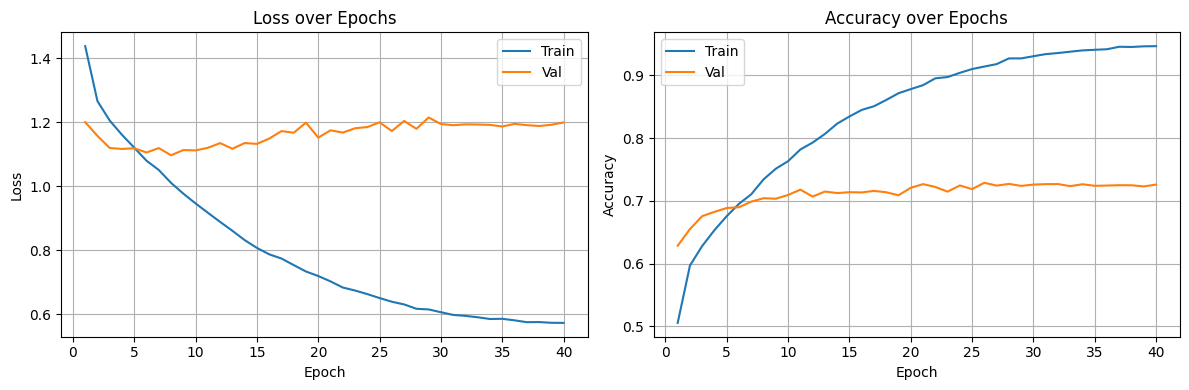


Final evaluation:
Precision: 0.7258, Recall: 0.7288, F1: 0.7262
Confusion Matrix:
[[ 600   12   84   45   79  128   10]
 [  17   76    7    3    3    5    0]
 [  94    4  554   31   91  190   60]
 [  14    1   12 1629   57   22   39]
 [  47    3   53   80  873  159   18]
 [  92    3  103   54  180  801   14]
 [  16    2   54   36   13   12  698]]


In [1]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_B1_Weights, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- Configurations and Hyperparameters ---
# Choose 'efficientnet' or 'mobilenet'
MODEL_NAME   = "efficientnet"
DATA_DIR     = "/home/roberh18/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
#DATA_DIR    = "/home/roberh18/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1/fer2013plus/fer2013"
BATCH_SIZE   = 32
NUM_EPOCHS   = 60
LEARNING_RATE= 4e-4
WEIGHT_DECAY = 8e-4
IMAGE_SIZE   = 224
LABEL_SMOOTH = 0.1
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Mean and Std Calculation ---
def calculate_mean_std(root, size, batch_size):
    """
    Compute global dataset mean and std over all pixels (not per-image).
    """
    print("Calculating mean and std...")
    tf = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    ds = datasets.ImageFolder(os.path.join(root, 'train'), transform=tf)
    ld = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)

    sum_pixels = torch.zeros(3)
    sum_squared = torch.zeros(3)
    total_pixels = 0

    for imgs, _ in ld:
        # imgs shape: [B, C, H, W]
        sum_pixels += imgs.sum(dim=[0, 2, 3])
        sum_squared += (imgs ** 2).sum(dim=[0, 2, 3])
        total_pixels += imgs.size(0) * imgs.size(2) * imgs.size(3)

    mean = sum_pixels / total_pixels
    std = torch.sqrt(sum_squared / total_pixels - mean ** 2)
    return mean.tolist(), std.tolist()

MEAN, STD = calculate_mean_std(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)
print(f"Dataset mean: {MEAN}\nDataset std:  {STD}")

# --- Data Transforms ---
train_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.5)
])
val_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# --- Datasets and DataLoaders ---
train_set = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_tf)
val_set   = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'),  transform=val_tf)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
NUM_CLASSES  = len(train_set.classes)

# --- Model Creation ---
def create_model(name, num_classes):
    if name == "efficientnet":
        m = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, num_classes))
    elif name == "mobilenet":
        m = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        in_f = m.classifier[3].in_features
        # classifier is [Dropout, Linear, Hardswish] on small? adjust last Linear
        m.classifier[3] = nn.Linear(in_f, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return m.to(DEVICE)

model = create_model(MODEL_NAME, NUM_CLASSES)

# --- Loss, Optimizer, Scheduler ---
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# --- Histories ---
train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

best_f1 = 0.0
best_w = copy.deepcopy(model.state_dict())

print("Begin Training...")
for epoch in range(1, NUM_EPOCHS+1):
    start_time = time.time()
    # --- Train ---
    model.train()
    tot_loss, tot_corr = 0.0, 0
    for x,y in train_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss= criterion(out,y)
        loss.backward(); optimizer.step()
        tot_loss += loss.item()*x.size(0)
        tot_corr += (out.argmax(1)==y).sum().item()
    tr_loss = tot_loss/len(train_set)
    tr_acc  = tot_corr/len(train_set)
    train_loss_hist.append(tr_loss)
    train_acc_hist.append(tr_acc)
    # --- Val ---
    model.eval()
    vt_loss, vt_corr = 0.0, 0
    all_p, all_t = [], []
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            out= model(x)
            l = criterion(out,y)
            vt_loss += l.item()*x.size(0)
            p = out.argmax(1)
            vt_corr += (p==y).sum().item()
            all_p.extend(p.cpu().tolist()); all_t.extend(y.cpu().tolist())
    v_loss = vt_loss/len(val_set)
    v_acc  = vt_corr/len(val_set)
    val_loss_hist.append(v_loss)
    val_acc_hist.append(v_acc)
    prec = precision_score(all_t, all_p, average='weighted', zero_division=0)
    rec  = recall_score(all_t, all_p, average='weighted', zero_division=0)
    f1   = f1_score(all_t, all_p, average='weighted', zero_division=0)
    elapsed = time.time()-start_time
    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
          f"Val Loss: {v_loss:.4f} Acc: {v_acc:.4f} | "
          f"F1: {f1:.4f} | {elapsed:.1f}s")
    if f1>best_f1:
        best_f1, best_w = f1, copy.deepcopy(model.state_dict())
    scheduler.step()

# --- Plot Loss & Accuracy ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,NUM_EPOCHS+1), train_loss_hist, label='Train')
plt.plot(range(1,NUM_EPOCHS+1), val_loss_hist,   label='Val')
plt.title('Loss over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid()
plt.subplot(1,2,2)
plt.plot(range(1,NUM_EPOCHS+1), train_acc_hist, label='Train')
plt.plot(range(1,NUM_EPOCHS+1), val_acc_hist,   label='Val')
plt.title('Accuracy over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid()
plt.tight_layout(); plt.show()

# --- Final Eval & Confusion Matrix ---
model.load_state_dict(best_w); model.eval()
all_p, all_t = [], []
with torch.no_grad():
    for x,y in val_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        p = model(x).argmax(1)
        all_p.extend(p.cpu()); all_t.extend(y.cpu())
prec = precision_score(all_t, all_p, average='weighted', zero_division=0)
rec  = recall_score(all_t, all_p, average='weighted', zero_division=0)
f1   = f1_score(all_t, all_p, average='weighted', zero_division=0)
cm   = confusion_matrix(all_t, all_p)
print("\nFinal evaluation:")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Save Model ---
os.makedirs("models", exist_ok=True)
torch.save(best_w, f"models/{MODEL_NAME}_best.pth")


Calculating mean and std...
Dataset mean: [0.507876455783844, 0.507876455783844, 0.507876455783844]
Dataset std:  [0.25019553303718567, 0.25019553303718567, 0.25019553303718567]
Begin Training...
Epoch 1/40 | Train Loss: 1.4743 Acc: 0.4812 | Val Loss: 1.2846 Acc: 0.5906 | F1: 0.5887 | 31.6s
Epoch 2/40 | Train Loss: 1.3213 Acc: 0.5673 | Val Loss: 1.2515 Acc: 0.6031 | F1: 0.5997 | 32.3s
Epoch 3/40 | Train Loss: 1.2729 Acc: 0.5939 | Val Loss: 1.1943 Acc: 0.6326 | F1: 0.6235 | 32.2s
Epoch 4/40 | Train Loss: 1.2375 Acc: 0.6104 | Val Loss: 1.1652 Acc: 0.6525 | F1: 0.6424 | 30.8s
Epoch 5/40 | Train Loss: 1.2101 Acc: 0.6254 | Val Loss: 1.1875 Acc: 0.6446 | F1: 0.6330 | 31.9s
Epoch 6/40 | Train Loss: 1.1834 Acc: 0.6418 | Val Loss: 1.1509 Acc: 0.6590 | F1: 0.6563 | 30.3s
Epoch 7/40 | Train Loss: 1.1584 Acc: 0.6504 | Val Loss: 1.1555 Acc: 0.6585 | F1: 0.6614 | 29.7s
Epoch 8/40 | Train Loss: 1.1414 Acc: 0.6610 | Val Loss: 1.1298 Acc: 0.6793 | F1: 0.6751 | 30.5s
Epoch 9/40 | Train Loss: 1.1206 Acc:

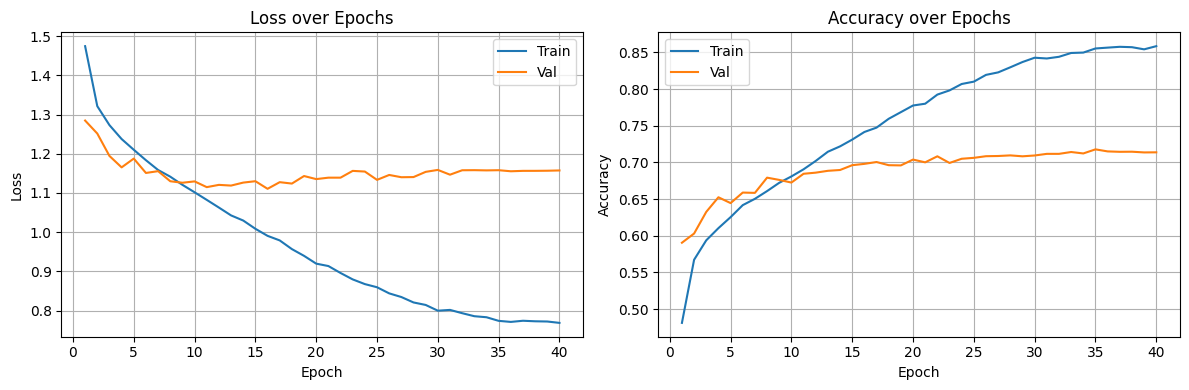


Final evaluation:
Precision: 0.7174, Recall: 0.7179, F1: 0.7171
Confusion Matrix:
[[ 624    5   87   30   86  107   19]
 [  22   75    4    0    3    5    2]
 [ 111    0  564   18   71  192   68]
 [  28    0   21 1575   88   23   39]
 [  58    3   67   72  858  156   19]
 [ 102    1  135   50  194  748   17]
 [  20    0   51   23   11   17  709]]


In [2]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_B1_Weights, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# --- Configurations and Hyperparameters ---
# Choose 'efficientnet' or 'mobilenet'
MODEL_NAME   = "mobilenet"
DATA_DIR     = "/home/roberh18/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
#DATA_DIR    = "/home/roberh18/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1/fer2013plus/fer2013"
BATCH_SIZE   = 32
NUM_EPOCHS   = 60
LEARNING_RATE= 4e-4
WEIGHT_DECAY = 8e-4
IMAGE_SIZE   = 224
LABEL_SMOOTH = 0.1
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Mean and Std Calculation ---
def calculate_mean_std(root, size, batch_size):
    """
    Compute global dataset mean and std over all pixels (not per-image).
    """
    print("Calculating mean and std...")
    tf = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    ds = datasets.ImageFolder(os.path.join(root, 'train'), transform=tf)
    ld = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)

    sum_pixels = torch.zeros(3)
    sum_squared = torch.zeros(3)
    total_pixels = 0

    for imgs, _ in ld:
        # imgs shape: [B, C, H, W]
        sum_pixels += imgs.sum(dim=[0, 2, 3])
        sum_squared += (imgs ** 2).sum(dim=[0, 2, 3])
        total_pixels += imgs.size(0) * imgs.size(2) * imgs.size(3)

    mean = sum_pixels / total_pixels
    std = torch.sqrt(sum_squared / total_pixels - mean ** 2)
    return mean.tolist(), std.tolist()

MEAN, STD = calculate_mean_std(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)
print(f"Dataset mean: {MEAN}\nDataset std:  {STD}")

# --- Data Transforms ---
train_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.5)
])
val_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# --- Datasets and DataLoaders ---
train_set = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_tf)
val_set   = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'),  transform=val_tf)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
NUM_CLASSES  = len(train_set.classes)

# --- Model Creation ---
def create_model(name, num_classes):
    if name == "efficientnet":
        m = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, num_classes))
    elif name == "mobilenet":
        m = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        in_f = m.classifier[3].in_features
        # classifier is [Dropout, Linear, Hardswish] on small? adjust last Linear
        m.classifier[3] = nn.Linear(in_f, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return m.to(DEVICE)

model = create_model(MODEL_NAME, NUM_CLASSES)

# --- Loss, Optimizer, Scheduler ---
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# --- Histories ---
train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

best_f1 = 0.0
best_w = copy.deepcopy(model.state_dict())

print("Begin Training...")
for epoch in range(1, NUM_EPOCHS+1):
    start_time = time.time()
    # --- Train ---
    model.train()
    tot_loss, tot_corr = 0.0, 0
    for x,y in train_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss= criterion(out,y)
        loss.backward(); optimizer.step()
        tot_loss += loss.item()*x.size(0)
        tot_corr += (out.argmax(1)==y).sum().item()
    tr_loss = tot_loss/len(train_set)
    tr_acc  = tot_corr/len(train_set)
    train_loss_hist.append(tr_loss)
    train_acc_hist.append(tr_acc)
    # --- Val ---
    model.eval()
    vt_loss, vt_corr = 0.0, 0
    all_p, all_t = [], []
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            out= model(x)
            l = criterion(out,y)
            vt_loss += l.item()*x.size(0)
            p = out.argmax(1)
            vt_corr += (p==y).sum().item()
            all_p.extend(p.cpu().tolist()); all_t.extend(y.cpu().tolist())
    v_loss = vt_loss/len(val_set)
    v_acc  = vt_corr/len(val_set)
    val_loss_hist.append(v_loss)
    val_acc_hist.append(v_acc)
    prec = precision_score(all_t, all_p, average='weighted', zero_division=0)
    rec  = recall_score(all_t, all_p, average='weighted', zero_division=0)
    f1   = f1_score(all_t, all_p, average='weighted', zero_division=0)
    elapsed = time.time()-start_time
    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
          f"Val Loss: {v_loss:.4f} Acc: {v_acc:.4f} | "
          f"F1: {f1:.4f} | {elapsed:.1f}s")
    if f1>best_f1:
        best_f1, best_w = f1, copy.deepcopy(model.state_dict())
    scheduler.step()

# --- Plot Loss & Accuracy ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,NUM_EPOCHS+1), train_loss_hist, label='Train')
plt.plot(range(1,NUM_EPOCHS+1), val_loss_hist,   label='Val')
plt.title('Loss over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid()
plt.subplot(1,2,2)
plt.plot(range(1,NUM_EPOCHS+1), train_acc_hist, label='Train')
plt.plot(range(1,NUM_EPOCHS+1), val_acc_hist,   label='Val')
plt.title('Accuracy over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid()
plt.tight_layout(); plt.show()

# --- Final Eval & Confusion Matrix ---
model.load_state_dict(best_w); model.eval()
all_p, all_t = [], []
with torch.no_grad():
    for x,y in val_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        p = model(x).argmax(1)
        all_p.extend(p.cpu()); all_t.extend(y.cpu())
prec = precision_score(all_t, all_p, average='weighted', zero_division=0)
rec  = recall_score(all_t, all_p, average='weighted', zero_division=0)
f1   = f1_score(all_t, all_p, average='weighted', zero_division=0)
cm   = confusion_matrix(all_t, all_p)
print("\nFinal evaluation:")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Save Model ---
os.makedirs("models", exist_ok=True)
torch.save(best_w, f"models/{MODEL_NAME}_best.pth")


Calculating mean and std...
Dataset mean: [0.5077897310256958, 0.5077897310256958, 0.5077897310256958]
Dataset std:  [0.2495584785938263, 0.2495584785938263, 0.2495584785938263]
Begin Training...
Epoch 1/40 | Train Loss: 1.1785 Acc: 0.6749 | Val Loss: 0.9035 Acc: 0.8010 | F1: 0.7867 | 80.7s
Epoch 2/40 | Train Loss: 0.9841 Acc: 0.7627 | Val Loss: 0.8724 Acc: 0.8157 | F1: 0.8039 | 81.1s
Epoch 3/40 | Train Loss: 0.9314 Acc: 0.7878 | Val Loss: 0.8710 Acc: 0.8115 | F1: 0.8015 | 80.5s
Epoch 4/40 | Train Loss: 0.8970 Acc: 0.8008 | Val Loss: 0.8370 Acc: 0.8277 | F1: 0.8187 | 80.3s
Epoch 5/40 | Train Loss: 0.8638 Acc: 0.8174 | Val Loss: 0.8311 Acc: 0.8311 | F1: 0.8283 | 80.4s
Epoch 6/40 | Train Loss: 0.8369 Acc: 0.8323 | Val Loss: 0.8323 Acc: 0.8328 | F1: 0.8313 | 80.3s
Epoch 7/40 | Train Loss: 0.8163 Acc: 0.8412 | Val Loss: 0.8354 Acc: 0.8318 | F1: 0.8262 | 80.4s
Epoch 8/40 | Train Loss: 0.7921 Acc: 0.8534 | Val Loss: 0.8275 Acc: 0.8394 | F1: 0.8369 | 80.4s
Epoch 9/40 | Train Loss: 0.7738 Acc:

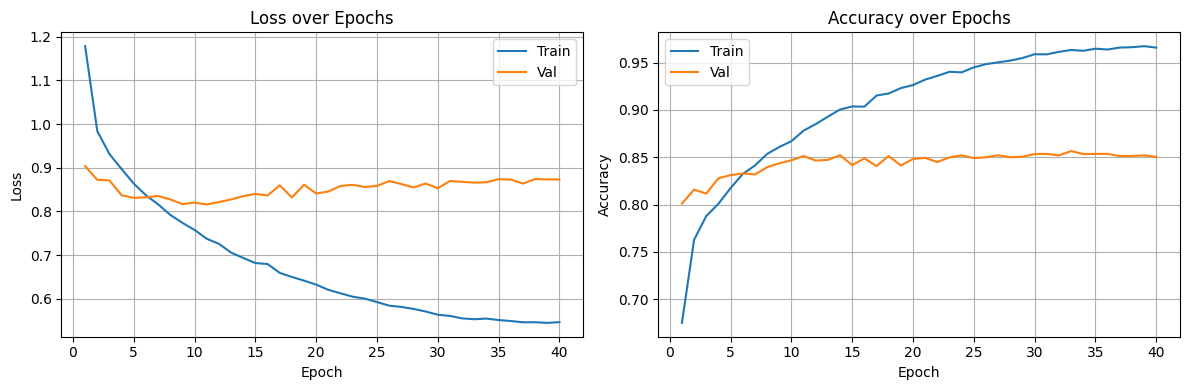


Final evaluation:
Precision: 0.8536, Recall: 0.8565, F1: 0.8533
Confusion Matrix:
[[ 520    1    3    4   22   60   24   10]
 [   4   15    1    1    0   22    8    0]
 [  17    0   29    0    2    5    2    2]
 [   9    0    0   86    3   10   17   42]
 [  14    0    1    2 1708   59   18   25]
 [  32    4    2    7   53 2346  116   37]
 [  21    1    0    7   18  219  584    6]
 [  19    0    0   19   23   43    4  792]]


In [3]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_B1_Weights, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# --- Configurations and Hyperparameters ---
# Choose 'efficientnet' or 'mobilenet'
MODEL_NAME   = "efficientnet"
#DATA_DIR     = "/home/roberh18/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
DATA_DIR    = "/home/roberh18/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1/fer2013plus/fer2013"
BATCH_SIZE   = 32
NUM_EPOCHS   = 60
LEARNING_RATE= 4e-4
WEIGHT_DECAY = 8e-4
IMAGE_SIZE   = 224
LABEL_SMOOTH = 0.1
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Mean and Std Calculation ---
def calculate_mean_std(root, size, batch_size):
    """
    Compute global dataset mean and std over all pixels (not per-image).
    """
    print("Calculating mean and std...")
    tf = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    ds = datasets.ImageFolder(os.path.join(root, 'train'), transform=tf)
    ld = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)

    sum_pixels = torch.zeros(3)
    sum_squared = torch.zeros(3)
    total_pixels = 0

    for imgs, _ in ld:
        # imgs shape: [B, C, H, W]
        sum_pixels += imgs.sum(dim=[0, 2, 3])
        sum_squared += (imgs ** 2).sum(dim=[0, 2, 3])
        total_pixels += imgs.size(0) * imgs.size(2) * imgs.size(3)

    mean = sum_pixels / total_pixels
    std = torch.sqrt(sum_squared / total_pixels - mean ** 2)
    return mean.tolist(), std.tolist()

MEAN, STD = calculate_mean_std(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)
print(f"Dataset mean: {MEAN}\nDataset std:  {STD}")

# --- Data Transforms ---
train_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.5)
])
val_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# --- Datasets and DataLoaders ---
train_set = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_tf)
val_set   = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'),  transform=val_tf)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
NUM_CLASSES  = len(train_set.classes)

# --- Model Creation ---
def create_model(name, num_classes):
    if name == "efficientnet":
        m = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, num_classes))
    elif name == "mobilenet":
        m = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        in_f = m.classifier[3].in_features
        # classifier is [Dropout, Linear, Hardswish] on small? adjust last Linear
        m.classifier[3] = nn.Linear(in_f, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return m.to(DEVICE)

model = create_model(MODEL_NAME, NUM_CLASSES)

# --- Loss, Optimizer, Scheduler ---
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# --- Histories ---
train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

best_f1 = 0.0
best_w = copy.deepcopy(model.state_dict())

print("Begin Training...")
for epoch in range(1, NUM_EPOCHS+1):
    start_time = time.time()
    # --- Train ---
    model.train()
    tot_loss, tot_corr = 0.0, 0
    for x,y in train_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss= criterion(out,y)
        loss.backward(); optimizer.step()
        tot_loss += loss.item()*x.size(0)
        tot_corr += (out.argmax(1)==y).sum().item()
    tr_loss = tot_loss/len(train_set)
    tr_acc  = tot_corr/len(train_set)
    train_loss_hist.append(tr_loss)
    train_acc_hist.append(tr_acc)
    # --- Val ---
    model.eval()
    vt_loss, vt_corr = 0.0, 0
    all_p, all_t = [], []
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            out= model(x)
            l = criterion(out,y)
            vt_loss += l.item()*x.size(0)
            p = out.argmax(1)
            vt_corr += (p==y).sum().item()
            all_p.extend(p.cpu().tolist()); all_t.extend(y.cpu().tolist())
    v_loss = vt_loss/len(val_set)
    v_acc  = vt_corr/len(val_set)
    val_loss_hist.append(v_loss)
    val_acc_hist.append(v_acc)
    prec = precision_score(all_t, all_p, average='weighted', zero_division=0)
    rec  = recall_score(all_t, all_p, average='weighted', zero_division=0)
    f1   = f1_score(all_t, all_p, average='weighted', zero_division=0)
    elapsed = time.time()-start_time
    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
          f"Val Loss: {v_loss:.4f} Acc: {v_acc:.4f} | "
          f"F1: {f1:.4f} | {elapsed:.1f}s")
    if f1>best_f1:
        best_f1, best_w = f1, copy.deepcopy(model.state_dict())
    scheduler.step()

# --- Plot Loss & Accuracy ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,NUM_EPOCHS+1), train_loss_hist, label='Train')
plt.plot(range(1,NUM_EPOCHS+1), val_loss_hist,   label='Val')
plt.title('Loss over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid()
plt.subplot(1,2,2)
plt.plot(range(1,NUM_EPOCHS+1), train_acc_hist, label='Train')
plt.plot(range(1,NUM_EPOCHS+1), val_acc_hist,   label='Val')
plt.title('Accuracy over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid()
plt.tight_layout(); plt.show()

# --- Final Eval & Confusion Matrix ---
model.load_state_dict(best_w); model.eval()
all_p, all_t = [], []
with torch.no_grad():
    for x,y in val_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        p = model(x).argmax(1)
        all_p.extend(p.cpu()); all_t.extend(y.cpu())
prec = precision_score(all_t, all_p, average='weighted', zero_division=0)
rec  = recall_score(all_t, all_p, average='weighted', zero_division=0)
f1   = f1_score(all_t, all_p, average='weighted', zero_division=0)
cm   = confusion_matrix(all_t, all_p)
print("\nFinal evaluation:")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Save Model ---
os.makedirs("models", exist_ok=True)
torch.save(best_w, f"models/{MODEL_NAME}_best.pth")


Calculating mean and std...
Dataset mean: [0.5077897310256958, 0.5077897310256958, 0.5077897310256958]
Dataset std:  [0.2495584785938263, 0.2495584785938263, 0.2495584785938263]
Begin Training...
Epoch 1/40 | Train Loss: 1.2275 Acc: 0.6466 | Val Loss: 0.9757 Acc: 0.7686 | F1: 0.7532 | 31.4s
Epoch 2/40 | Train Loss: 1.0550 Acc: 0.7263 | Val Loss: 0.9688 Acc: 0.7756 | F1: 0.7523 | 30.0s
Epoch 3/40 | Train Loss: 1.0060 Acc: 0.7501 | Val Loss: 0.9252 Acc: 0.7939 | F1: 0.7820 | 29.9s
Epoch 4/40 | Train Loss: 0.9686 Acc: 0.7692 | Val Loss: 0.8739 Acc: 0.8097 | F1: 0.8026 | 30.6s
Epoch 5/40 | Train Loss: 0.9441 Acc: 0.7777 | Val Loss: 0.8664 Acc: 0.8145 | F1: 0.8050 | 30.3s
Epoch 6/40 | Train Loss: 0.9195 Acc: 0.7919 | Val Loss: 0.8736 Acc: 0.8121 | F1: 0.8033 | 30.4s
Epoch 7/40 | Train Loss: 0.9033 Acc: 0.7999 | Val Loss: 0.8878 Acc: 0.8087 | F1: 0.8003 | 30.3s
Epoch 8/40 | Train Loss: 0.8863 Acc: 0.8055 | Val Loss: 0.8511 Acc: 0.8242 | F1: 0.8175 | 30.1s
Epoch 9/40 | Train Loss: 0.8633 Acc:

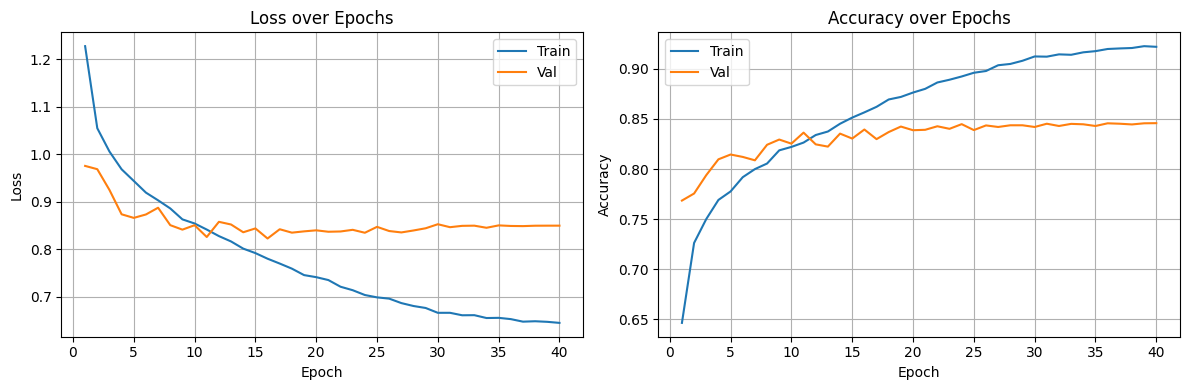


Final evaluation:
Precision: 0.8435, Recall: 0.8456, F1: 0.8431
Confusion Matrix:
[[ 502    0    3    7   24   68   25   15]
 [   3   16    1    1    0   24    6    0]
 [  12    1   29    1    2    4    6    2]
 [   5    0    0   86    2   10   17   47]
 [  22    1    1    0 1698   55   23   27]
 [  29    1    0    5   60 2296  170   36]
 [  21    2    3   11   19  213  584    3]
 [  21    0    0   12   24   49    2  792]]


In [4]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_B1_Weights, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# --- Configurations and Hyperparameters ---
# Choose 'efficientnet' or 'mobilenet'
MODEL_NAME   = "mobilenet"
#DATA_DIR     = "/home/roberh18/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
DATA_DIR    = "/home/roberh18/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1/fer2013plus/fer2013"
BATCH_SIZE   = 32
NUM_EPOCHS   = 60
LEARNING_RATE= 4e-4
WEIGHT_DECAY = 8e-4
IMAGE_SIZE   = 224
LABEL_SMOOTH = 0.1
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Mean and Std Calculation ---
def calculate_mean_std(root, size, batch_size):
    """
    Compute global dataset mean and std over all pixels (not per-image).
    """
    print("Calculating mean and std...")
    tf = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    ds = datasets.ImageFolder(os.path.join(root, 'train'), transform=tf)
    ld = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)

    sum_pixels = torch.zeros(3)
    sum_squared = torch.zeros(3)
    total_pixels = 0

    for imgs, _ in ld:
        # imgs shape: [B, C, H, W]
        sum_pixels += imgs.sum(dim=[0, 2, 3])
        sum_squared += (imgs ** 2).sum(dim=[0, 2, 3])
        total_pixels += imgs.size(0) * imgs.size(2) * imgs.size(3)

    mean = sum_pixels / total_pixels
    std = torch.sqrt(sum_squared / total_pixels - mean ** 2)
    return mean.tolist(), std.tolist()

MEAN, STD = calculate_mean_std(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)
print(f"Dataset mean: {MEAN}\nDataset std:  {STD}")

# --- Data Transforms ---
train_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.5)
])
val_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# --- Datasets and DataLoaders ---
train_set = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_tf)
val_set   = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'),  transform=val_tf)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
NUM_CLASSES  = len(train_set.classes)

# --- Model Creation ---
def create_model(name, num_classes):
    if name == "efficientnet":
        m = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, num_classes))
    elif name == "mobilenet":
        m = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        in_f = m.classifier[3].in_features
        # classifier is [Dropout, Linear, Hardswish] on small? adjust last Linear
        m.classifier[3] = nn.Linear(in_f, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return m.to(DEVICE)

model = create_model(MODEL_NAME, NUM_CLASSES)

# --- Loss, Optimizer, Scheduler ---
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# --- Histories ---
train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

best_f1 = 0.0
best_w = copy.deepcopy(model.state_dict())

print("Begin Training...")
for epoch in range(1, NUM_EPOCHS+1):
    start_time = time.time()
    # --- Train ---
    model.train()
    tot_loss, tot_corr = 0.0, 0
    for x,y in train_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss= criterion(out,y)
        loss.backward(); optimizer.step()
        tot_loss += loss.item()*x.size(0)
        tot_corr += (out.argmax(1)==y).sum().item()
    tr_loss = tot_loss/len(train_set)
    tr_acc  = tot_corr/len(train_set)
    train_loss_hist.append(tr_loss)
    train_acc_hist.append(tr_acc)
    # --- Val ---
    model.eval()
    vt_loss, vt_corr = 0.0, 0
    all_p, all_t = [], []
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            out= model(x)
            l = criterion(out,y)
            vt_loss += l.item()*x.size(0)
            p = out.argmax(1)
            vt_corr += (p==y).sum().item()
            all_p.extend(p.cpu().tolist()); all_t.extend(y.cpu().tolist())
    v_loss = vt_loss/len(val_set)
    v_acc  = vt_corr/len(val_set)
    val_loss_hist.append(v_loss)
    val_acc_hist.append(v_acc)
    prec = precision_score(all_t, all_p, average='weighted', zero_division=0)
    rec  = recall_score(all_t, all_p, average='weighted', zero_division=0)
    f1   = f1_score(all_t, all_p, average='weighted', zero_division=0)
    elapsed = time.time()-start_time
    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
          f"Val Loss: {v_loss:.4f} Acc: {v_acc:.4f} | "
          f"F1: {f1:.4f} | {elapsed:.1f}s")
    if f1>best_f1:
        best_f1, best_w = f1, copy.deepcopy(model.state_dict())
    scheduler.step()

# --- Plot Loss & Accuracy ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,NUM_EPOCHS+1), train_loss_hist, label='Train')
plt.plot(range(1,NUM_EPOCHS+1), val_loss_hist,   label='Val')
plt.title('Loss over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid()
plt.subplot(1,2,2)
plt.plot(range(1,NUM_EPOCHS+1), train_acc_hist, label='Train')
plt.plot(range(1,NUM_EPOCHS+1), val_acc_hist,   label='Val')
plt.title('Accuracy over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid()
plt.tight_layout(); plt.show()

# --- Final Eval & Confusion Matrix ---
model.load_state_dict(best_w); model.eval()
all_p, all_t = [], []
with torch.no_grad():
    for x,y in val_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        p = model(x).argmax(1)
        all_p.extend(p.cpu()); all_t.extend(y.cpu())
prec = precision_score(all_t, all_p, average='weighted', zero_division=0)
rec  = recall_score(all_t, all_p, average='weighted', zero_division=0)
f1   = f1_score(all_t, all_p, average='weighted', zero_division=0)
cm   = confusion_matrix(all_t, all_p)
print("\nFinal evaluation:")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Save Model ---
os.makedirs("models", exist_ok=True)
torch.save(best_w, f"models/{MODEL_NAME}_best.pth")
